Materiał na podstawie:
- http://docs.julialang.org/en/stable/manual
- książki Avik Senegupta Julia High Performance 
- materiałów Piotra Gawrona (Instytut Informatyki Teoretycznej i Stosowanej PAN)


### Plan

- Narzedzia do pomiaru i analizy wydajnosci
- Na co zwracać uwagę przy pisaniu programów w Julii:
  - Typy
  - Kontenery
  - Funkcje
- Makra przyspieszające działanie programu
- Makra pokazujace kod na różnych etapach analizy przez kompilator 


### Profiler - ogólnie 
- narzędzie do dynamicznej analizy danych
- mierzy np. czas wykonania, zużytą pamięć, częstość wywołań funkcji itd.
- techniki zbierania danych:
   - event-based: zbieranie danych podczas dobrze zdefiniowanych zdarzeń (np. wejścia do funkcji)
   - statistical: zbiera dane statystyczne w regularnych odstępach czasu wykorzystując przerwania systemu 
   - instrumented: do kodu dodaje się instrukcje zbierające dane, uwaga na  heisenbugs !
   - simulation based: zbiera dane uruchamiając niezmodikowany program w symulowanym środowisku

### Profiler w Julii
- Statistical: 1 ms (Unix systems), 10 ms (Windows), 
- faktycznie odstępy czasu zależą od obciążenia systemu
- wynikiem jest tzw backtrace - "zdjęcie" danego stanu wykonania 
- każdy backtrace zawiera:
  - wykonującą się właśnie funkcję i jej numer lini w kodzie
  - łańcuch wszystkich wywołań prowadzący do tej linii kodu

### Wady i zalety profilera w Julii
- Zalety:
   - nie trzeba modyfikować kodu
   - można używać do Julii, ale też do innych języków z niej wywoływanych
   - minimalny narzut (użycie profilera nie spowalnia kodu)
- Wady 
   - szum statystyczny, 
   - może  nie wyłapać wszystkich istotnych wywołań 


## Narzędzia do oceny wydajności

In [1]:
function myfunc(n)
    for i = 1:n
        A=rand(100, 300, 200)
        maximum(A)
    end
end


myfunc (generic function with 1 method)

In [2]:
myfunc(1) # kompilacja (za pierwszym razem wykonanie trwa dluzej)

In [3]:
Profile.clear()
@profile myfunc(10)

In [4]:
Profile.print()

788 ./task.jl:360; (::IJulia.##13#19)()
 788 ...Julia/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  788 ...rc/execute_request.jl:157; execute_request(::ZMQ.Socket, ::...
   788 ./loading.jl:441; include_string(::String, ::String)
    788 ./<missing>:?; anonymous
     788 ./profile.jl:16; macro expansion;
      454 ./In[1]:3; myfunc(::Int64)
       281 ./random.jl:362; rand!(::MersenneTwister, ::Ar...
        281 ./dSFMT.jl:84; dsfmt_fill_array_close_open!(...
       173 ./random.jl:230; rand
        173 ./random.jl:229; rand
         173 ./random.jl:297; rand
          173 ./random.jl:300; rand
      334 ./In[1]:4; myfunc(::Int64)
       334 ./reduce.jl:162; _mapreduce(::Base.#identity, ...
        27  ./reduce.jl:272; mapreduce_impl(::Base.#identi...
        16  ./reduce.jl:278; mapreduce_impl(::Base.#identi...
        290 ./reduce.jl:280; mapreduce_impl(::Base.#identi...
        1   ./reduce.jl:281; mapreduce_impl(::Base.#identi...


In [5]:
Profile.print(format=:flat)

 Count File                        Line Function                               
   788 ./<missing>                   -1 anonymous                              
   454 ./In[1]                        3 myfunc(::Int64)                        
   334 ./In[1]                        4 myfunc(::Int64)                        
   281 ./dSFMT.jl                    84 dsfmt_fill_array_close_open!(::Base... 
   788 ./loading.jl                 441 include_string(::String, ::String)     
   788 ./profile.jl                  16 macro expansion;                       
   281 ./random.jl                  362 rand!(::MersenneTwister, ::Array{Fl... 
   173 ./random.jl                  229 rand                                   
   173 ./random.jl                  230 rand                                   
   173 ./random.jl                  297 rand                                   
   173 ./random.jl                  300 rand                                   
   334 ./reduce.jl                  162 

Uwaga: graficzna wersja profilera wymaga doinstalowania 
```julia
Pkg.add("ProfileView")
```

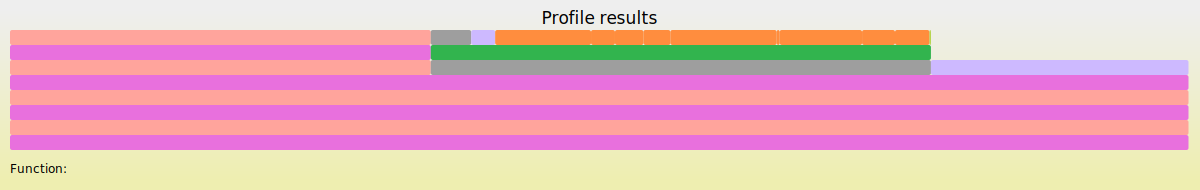

In [6]:
using ProfileView
ProfileView.view()

In [7]:
Profile.clear()

In [8]:
function profile_test(n)
    for i = 1:n
        A = randn(100,100,20)
        m = maximum(A)
        Afft = fft(A)
        Am = mapslices(sum, A, 2)
        B = A[:,:,5]
        Bsort = mapslices(sort, B, 1)
        b = rand(100)
        C = B.*b
    end
end

profile_test(1)  # kompilacja
Profile.clear()  # usuń dane z poprzedniego profilowania
@profile profile_test(10)

In [9]:
Profile.print()

247 ./task.jl:360; (::IJulia.##13#19)()
 247 ...Julia/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  247 ...rc/execute_request.jl:157; execute_request(::ZMQ.Socket, ::...
   247 ./loading.jl:441; include_string(::String, ::String)
    247 ./<missing>:?; anonymous
     247 ./profile.jl:16; macro expansion;
      34  ./In[8]:3; profile_test(::Int64)
       26 ./random.jl:1208; randn!(::MersenneTwister, ::A...
        5  ./random.jl:0; randn(::MersenneTwister, ::Ty...
        17 ./random.jl:1202; randn(::MersenneTwister, ::Ty...
         7 ./random.jl:1130; randn
          7 ./random.jl:263; rand_ui52
           7 ./random.jl:125; rand_ui52_raw
            3 ./random.jl:124; rand_ui52_raw_inbounds
             3 ./random.jl:117; rand_inbounds
              3 ./random.jl:104; mt_pop!
            4 ./random.jl:111; reserve_1
             4 ./random.jl:107; gen_rand
              4 ./dSFMT.jl:75; dsfmt_fill_array_close1_ope...
         1 ./random.jl:1131; randn
         7 ./random.jl:1133; ra

In [10]:
Profile.print(format=:flat)

 Count File                        Line Function                               
   247 ./<missing>                   -1 anonymous                              
    34 ./In[8]                        3 profile_test(::Int64)                  
    15 ./In[8]                        4 profile_test(::Int64)                  
   103 ./In[8]                        5 profile_test(::Int64)                  
    85 ./In[8]                        6 profile_test(::Int64)                  
     2 ./In[8]                        7 profile_test(::Int64)                  
     7 ./In[8]                        8 profile_test(::Int64)                  
     1 ./In[8]                       10 profile_test(::Int64)                  
     1 ./abstractarray.jl           284 checkbounds                            
    12 ./abstractarray.jl           559 copy!(::Base.LinearFast, ::Array{Co... 
     2 ./abstractarray.jl           653 copymutable                            
     1 ./abstractarray.jl          1623 

Uwaga: graficzna wersja profilera wymaga doinstalowania 
```julia
Pkg.add("ProfileView")
```

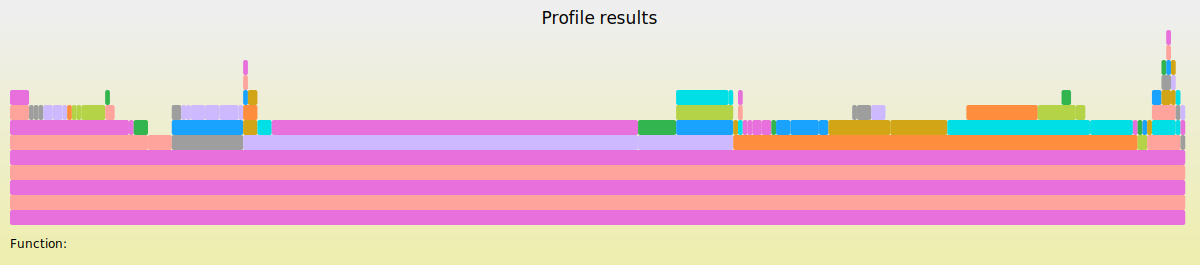

In [11]:
using ProfileView
ProfileView.view()

In [12]:
# Sprawdzanie alokacji pamięci (ilość zaalokowanej pamięci w bytes)

@allocated fft(randn(10,10))

858268

In [13]:
# Sprawdzanie czasu obliczeń, ilości alokacji itp.
@time fft(randn(10,10))

  0.011253 seconds (259 allocations: 19.516 KB)


10×10 Array{Complex{Float64},2}:
   7.85056+0.0im       -3.79182+1.32485im   …   -3.79182-1.32485im 
  -4.94292-2.15768im    7.00043-8.72064im        3.08369-8.19495im 
   11.2127+3.93277im   -1.46013-1.93623im      -0.305024+4.67589im 
 0.0799629+7.03881im   -16.4801-4.69813im        2.35229+6.87349im 
  -4.07138+7.74736im    8.40075+0.833407im      -6.68933-7.72076im 
   -4.8469+0.0im        3.83038-4.94247im   …    3.83038+4.94247im 
  -4.07138-7.74736im   -6.68933+7.72076im        8.40075-0.833407im
 0.0799629-7.03881im    2.35229-6.87349im       -16.4801+4.69813im 
   11.2127-3.93277im  -0.305024-4.67589im       -1.46013+1.93623im 
  -4.94292+2.15768im    3.08369+8.19495im        7.00043+8.72064im 

In [14]:
@timev fft(randn(10,10))

  0.000242 seconds (79 allocations: 8.531 KB)
elapsed time (ns): 241675
bytes allocated:   8736
pool allocs:       79


10×10 Array{Complex{Float64},2}:
   2.40163+0.0im       -17.6801+7.36863im   …   -17.6801-7.36863im 
   -6.7844+1.72675im   -8.62397-0.167337im       2.91742+9.3997im  
   11.9605+2.04336im   -1.16494+10.772im         9.76285+2.24219im 
   -5.2185-3.01078im  -0.128311-4.02872im        11.5898-7.54955im 
 -0.923558+4.37222im    4.73713-4.55217im        5.33043+5.14325im 
 -0.448956+0.0im       -9.98701-3.89179im   …   -9.98701+3.89179im 
 -0.923558-4.37222im    5.33043-5.14325im        4.73713+4.55217im 
   -5.2185+3.01078im    11.5898+7.54955im      -0.128311+4.02872im 
   11.9605-2.04336im    9.76285-2.24219im       -1.16494-10.772im  
   -6.7844-1.72675im    2.91742-9.3997im        -8.62397+0.167337im

In [15]:
tic(); fft(randn(10,10)); toc();

elapsed time: 0.019018838 seconds


In [16]:
#jeśli chcemy dostać wynik pomiaru, jako wartość:
@elapsed(fft(randn(10,10)))

0.00027932

Powyższe makra (@time etc)  sa użyteczne, jeśli chcemy zidentyfikować wąskie gardlo w programie, nie sa jednak dobre, jeśli chcemy  analizować program na drobnoziarnistym poziomie. Wtedy możemy użyc pakietu BenchmarkTools
Uwaga: wymaga doinstalowania 
```julia
Pkg.add("BenchmarkTools")
```

In [17]:
using BenchmarkTools
@benchmark fft(rand(10,10))

BenchmarkTools.Trial: 
  memory estimate:  8.38 KiB
  allocs estimate:  75
  --------------
  minimum time:     68.526 μs (0.00% GC)
  median time:      76.307 μs (0.00% GC)
  mean time:        93.970 μs (8.71% GC)
  maximum time:     37.917 ms (78.85% GC)
  --------------
  samples:          10000
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

## Pisanie wydajnych programów

In [18]:
# Dlaczego typy są ważne (statyczność typów). 
pos(x) = x < 0 ? 0 : x

function f(x)
    y = pos(x)
    sin(y*x+1)
end
#wykrywamy niepewne typy, widać że ciało funkcji jest dluższe.
@code_warntype f(3.2)

Variables:
  #self#::#f
  x::Float64
  y::Union{Float64,Int64}
  fy::Float64
  #temp#@_5::Union{Float64,Int64}
  #temp#@_6::LambdaInfo
  #temp#@_7::Float64

Body:
  begin 
      # meta: location In[18] pos 2
      # meta: location float.jl < 332
      fy::Float64 = (Base.box)(Float64,(Base.sitofp)(Float64,0))
      # meta: pop location
      unless (Base.box)(Base.Bool,(Base.or_int)((Base.lt_float)(x::Float64,fy::Float64)::Bool,(Base.box)(Base.Bool,(Base.and_int)((Base.box)(Base.Bool,(Base.and_int)((Base.eq_float)(x::Float64,fy::Float64)::Bool,(Base.lt_float)(fy::Float64,9.223372036854776e18)::Bool)),(Base.slt_int)((Base.box)(Int64,(Base.fptosi)(Int64,fy::Float64)),0)::Bool)))) goto 8
      #temp#@_5::Union{Float64,Int64} = 0
      goto 10
      8: 
      #temp#@_5::Union{Float64,Int64} = x::Float64
      10: 
      # meta: pop location
      y::Union{Float64,Int64} = #temp#@_5::Union{Float64,Int64} # line 6:
      unless (Core.isa)(y::Union{Float64,Int64},Float64)::Any goto 17
      #

In [19]:
pos2(x) = x < 0.0 ? 0.0 : x
function f2(x)
    y = pos2(x)
    sin(y*x+1)
end
@code_warntype f2(3.2)

Variables:
  #self#::#f2
  x::Float64
  y::Float64
  #temp#::Float64

Body:
  begin 
      # meta: location In[19] pos2 1
      unless (Base.lt_float)(x::Float64,0.0)::Bool goto 5
      #temp#::Float64 = 0.0
      goto 7
      5: 
      #temp#::Float64 = x::Float64
      7: 
      # meta: pop location
      y::Float64 = #temp#::Float64 # line 4:
      return $(Expr(:invoke, LambdaInfo for sin(::Float64), :(Main.sin), :((Base.box)(Base.Float64,(Base.add_float)((Base.box)(Base.Float64,(Base.mul_float)(y,x)),(Base.box)(Float64,(Base.sitofp)(Float64,1)))))))
  end::Float64


### Zmienne globalne
- Unikać zmiennych globalnych, ponieważ są trudne do optymalizacji dla kompilatora,
- jeśli kod jest krytyczny ze względu na wydajność, lepiej zamknąć go w funkcji.
  + W REPLu wszystkie zmienne są globalne
      ```julia
      julia> x = 1.0
      julia> global x = 1.0
      ```
  + Zmienne globalne należy annotować typami w miejscu ich faktycznego uzycia
      ```julia
      global x
      y = f(x::Int + 1)
      ```
  + Uczynienie zmiennej globalnej stala poprawia wydajność:
     ```julia
          const DEFAULT_VAL = 0
      ```


### Typy - optymalizacja

- Należy deklarować typy pola typów złożonych

Źle
```julia
type Foo
    field
end
```

Dobrze
```julia
type Foo
    field::Float64
end
```

Jesli "a" może być różnego typu, to lepiej użyć typów parametrycznych np:

In [20]:
 type MyType{T<:AbstractFloat}
         a::T
 end

niz np.

In [21]:
type MyStillAmbiguousType
         a::AbstractFloat
end

Ponieważ w pierwszym przypadku kompilator ustawi typ na podstawie typu podanego w trakcie wykonania np:

In [22]:
 m = MyType(3.2)

MyType{Float64}(3.2)

In [23]:
t = MyStillAmbiguousType(3.2)

MyStillAmbiguousType(3.2)

In [24]:
typeof(m)

MyType{Float64}

In [25]:
typeof(t)

MyStillAmbiguousType

W typie t można zmieniać typ pola, natomiast w typie m jest on 
juz ustawiony na stałe (dzięki czemu kompilator może wygenerować bardziej optymalny kod):

In [26]:
typeof(t.a)

Float64

In [27]:
t.a=4.5f0
typeof(t.a)

Float32

In [28]:
typeof(m.a)

Float64

In [29]:
m.a=4.5f0
typeof(m.a)

Float64

Możemy to ominąć poprzez wymuszenie typu AbstractFloat explicite (wtedy działa tak samo jak typ MyStillAmbiguousType)

In [30]:
m = MyType{AbstractFloat}(3.2)
typeof(m.a)

Float64

In [31]:
m.a=4.5f0
typeof(m.a)

Float32


Dlaczego to ma znaczenie można zobaczyć porównujac ilość kodu:

In [32]:
func(m::MyType) = m.a+1


func (generic function with 1 method)

In [33]:
code_llvm(func,(MyType{Float64},))


define double @julia_func_72618(%jl_value_t*) #0 {
top:
  %1 = bitcast %jl_value_t* %0 to double*
  %2 = load double, double* %1, align 16
  %3 = fadd double %2, 1.000000e+00
  ret double %3
}


In [34]:
code_llvm(func,(MyType{AbstractFloat},))


define %jl_value_t* @julia_func_72621(%jl_value_t*) #0 {
top:
  %ptls_i8 = call i8* asm "movq %fs:0, $0;\0Aaddq $$-2672, $0", "=r,~{dirflag},~{fpsr},~{flags}"() #2
  %ptls = bitcast i8* %ptls_i8 to %jl_value_t***
  %1 = alloca [5 x %jl_value_t*], align 8
  %.sub = getelementptr inbounds [5 x %jl_value_t*], [5 x %jl_value_t*]* %1, i64 0, i64 0
  %2 = getelementptr [5 x %jl_value_t*], [5 x %jl_value_t*]* %1, i64 0, i64 2
  %3 = bitcast %jl_value_t** %2 to i8*
  call void @llvm.memset.p0i8.i32(i8* %3, i8 0, i32 24, i32 8, i1 false)
  %4 = bitcast [5 x %jl_value_t*]* %1 to i64*
  store i64 6, i64* %4, align 8
  %5 = getelementptr [5 x %jl_value_t*], [5 x %jl_value_t*]* %1, i64 0, i64 1
  %6 = bitcast i8* %ptls_i8 to i64*
  %7 = load i64, i64* %6, align 8
  %8 = bitcast %jl_value_t** %5 to i64*
  store i64 %7, i64* %8, align 8
  store %jl_value_t** %.sub, %jl_value_t*** %ptls, align 8
  %9 = getelementptr [5 x %jl_value_t*], [5 x %jl_value_t*]* %1, i64 0, i64 4
  %10 = getelementptr [5 x %

In [35]:
code_llvm(func,(MyType,))

# WARNING: This code may not match what actually runs.

define %jl_value_t* @julia_func_72624(%jl_value_t*) #0 {
top:
  %ptls_i8 = call i8* asm "movq %fs:0, $0;\0Aaddq $$-2672, $0", "=r,~{dirflag},~{fpsr},~{flags}"() #2
  %ptls = bitcast i8* %ptls_i8 to %jl_value_t***
  %1 = alloca [7 x %jl_value_t*], align 8
  %.sub = getelementptr inbounds [7 x %jl_value_t*], [7 x %jl_value_t*]* %1, i64 0, i64 0
  %2 = getelementptr [7 x %jl_value_t*], [7 x %jl_value_t*]* %1, i64 0, i64 2
  %3 = bitcast %jl_value_t** %2 to i8*
  call void @llvm.memset.p0i8.i32(i8* %3, i8 0, i32 40, i32 8, i1 false)
  %4 = bitcast [7 x %jl_value_t*]* %1 to i64*
  store i64 10, i64* %4, align 8
  %5 = getelementptr [7 x %jl_value_t*], [7 x %jl_value_t*]* %1, i64 0, i64 1
  %6 = bitcast i8* %ptls_i8 to i64*
  %7 = load i64, i64* %6, align 8
  %8 = bitcast %jl_value_t** %5 to i64*
  store i64 %7, i64* %8, align 8
  store %jl_value_t** %.sub, %jl_value_t*** %ptls, align 8
  %9 = getelementptr [7 x %jl_value_t*], [7 x %jl_

### kontenery - optymalizacja

In [36]:
# Nieoptymalnie- nieciagły obszar w pamieci

a = Real[]    # typeof(a) = Array{Real,1}
if (f3 = rand()) < .8
    push!(a, f3)
end
a

1-element Array{Real,1}:
 0.12136

In [37]:
# Optymalnie- ciągły obszar w pamieci

a = Float64[] # typeof(a) = Array{Float64,1}
if (x2 = rand()) < .8
    push!(a, x2)
end
a

1-element Array{Float64,1}:
 0.340361

In [38]:
#kontener na rozne typy kolekcji, pierwszy sposob jest bardziej optymalny
type MySimpleContainer{A<:AbstractVector}
         a::A
end

In [39]:
#tutaj kompilator nie wie nic o typie kolekcji
type MyAmbiguousContainer{T}
         a::AbstractVector{T}
end

In [40]:
c = MySimpleContainer(1:3);
typeof(c)

MySimpleContainer{UnitRange{Int64}}

In [41]:
c = MySimpleContainer([1:3;]);
typeof(c)

MySimpleContainer{Array{Int64,1}}

In [42]:
b = MyAmbiguousContainer(1:3);
typeof(b)

MyAmbiguousContainer{Int64}

In [43]:
b = MyAmbiguousContainer([1:3;]);
typeof(b)

MyAmbiguousContainer{Int64}

In [44]:
#jeśli zawartość kontenera ma zmienne różnych typów, na których chcemy działac w różny sposób, 
# powinnismy wydzielić i napisać osobne funkcje dla tych typow
function sumfoo(c::MySimpleContainer)
    s = 0
for x in c.a
    s += foo(x)
end
s
end

foo(x::Integer) = x
foo(x::AbstractFloat) = round(x)

foo (generic function with 2 methods)

In [45]:
sumfoo(c)

6

A co jeśli chcemy mieć w ogóle różne funkcje dla różnych typow? 
Wtedy musielibyśmy pisać odrębne funcje dla typów
```julia
function myfun{T<:AbstractFloat}(c::MySimpleContainer{Vector{T}})
    ...
end

function myfun{T<:Integer}(c::MySimpleContainer{Vector{T}})
    ...
end
```

In [46]:
#A jeśli mamy różne typy ORAZ kolekcje? 
#Można stworzyć kontener dla różnych typow kolekcji i różnych typów zawartości tych kolekcji
type MyContainer2{T, A<:AbstractVector}
    a::A
end
# zewnętrzny konstruktor
MyContainer2(v::AbstractVector) = MyContainer2{eltype(v), typeof(v)}(v)
b = MyContainer2(1.3:5);
typeof(b)

MyContainer2{Float64,FloatRange{Float64}}

In [47]:
#teraz możemy tworzyć różne funkcje w zależności od typów kolekcji i ich zawartości

function myfunc2{T<:Integer, A<:AbstractVector}(c::MyContainer2{T,A})
    return c.a[1]+1
end

#     To powyżej można napisać bardziej zwięźle:
#     function myfunc{T<:Integer}(c::MyContainer2{T})

function myfunc2{T<:AbstractFloat}(c::MyContainer2{T})
    return c.a[1]+2
end

function myfunc2{T<:Integer}(c::MyContainer2{T,Vector{T}})
    return c.a[1]+3
end

myfunc2 (generic function with 3 methods)

In [48]:
myfunc2(MyContainer2(1:3))

2

In [49]:
myfunc2(MyContainer2(1.0:3))

3.0

In [50]:
 myfunc2(MyContainer2([1,2,3]))

4

In [51]:
# istnieje wada w tym  rozwiazaniu: nie mamy zapewnione ze
# typ T zgadza sie z typem elementow przechowywanych w kolekcji typu A
#taki kontener daje sie utworzyc, choc nie ma sensu:
b = MyContainer2{Int64, FloatRange{Float64}}(1.3:5);
typeof(b)

MyContainer2{Int64,FloatRange{Float64}}

In [52]:
#dodanie konstruktora wewnetrznego zalatwia ten problem:
type MyBetterContainer{T<:Real, A<:AbstractVector}
    a::A

    MyBetterContainer(v::AbstractVector{T}) = new(v)
end
MyBetterContainer(v::AbstractVector) = MyBetterContainer{eltype(v),typeof(v)}(v)

MyBetterContainer{T<:Real,A<:AbstractArray{T,1}}

In [53]:
b = MyBetterContainer(1.3:5);
typeof(b)

MyBetterContainer{Float64,FloatRange{Float64}}

In [54]:
# teraz nie zadziała:
b = MyBetterContainer{Int64, FloatRange{Float64}}(1.3:5)

LoadError: MethodError: Cannot `convert` an object of type FloatRange{Float64} to an object of type MyBetterContainer{Int64,FloatRange{Float64}}
This may have arisen from a call to the constructor MyBetterContainer{Int64,FloatRange{Float64}}(...),
since type constructors fall back to convert methods.

- Należy anotować typami wartości przypisywane do nieznanych typów

```julia
function foo(a::Array{Any,1})
    x = a[1]::Int32
    b = x+1
    ...
end
```

- Argumenty słów-kluczowy powinny mieć typ, poniewaz zmiejszaja narzut jej wywolania:
```julia
function with_keyword(x; name::Int = 1)
    ...
end
```

- Należy zachować stabilność typów 
- np. tutaj jest źle, bo x z typu Int staje się Float w srodku pętli:

```julia
function foo()
    x = 1
    for i = 1:10
        x = x/bar()
    end
    return x
end
```

Jak to naprawić (możliwości):
    - zaincjalizować x = 1.0
    - zadeklarować typ x: x::Float64 = 1
    - konwersja


### Funkcje

- Funkcje należy dzielić na mniejsze
    - kompilator moze wybrać wlaściwy kod bardziej optymalnie
    - albo nawet zrobic funkcje inline (wklejaną w miejsce pamieci, gdzie zostala wywolana)

Nieoptymalnie
```julia
function norm(A)
    if isa(A, Vector)
        return sqrt(real(dot(A,A)))
    elseif isa(A, Matrix)
        return max(svd(A)[2])
    else
        error("norm: invalid argument")
    end
end
```
Optymalnie:
```Julia
norm(x::Vector) = sqrt(real(dot(x,x)))
norm(A::Matrix) = max(svd(A)[2])
```

- Należy wydzielac funkcje, dla których bedzie wiadomo, na jakim typie operują 

Nieoptymalnie, ponieważ pętla for nie może być zopytmalizowana pod zawartość tablicy:

```julia
function strange_twos(n)
    a = Array(rand(Bool) ? Int64 : Float64, n)
    for i = 1:n
        a[i] = 2
    end
    return a
end
```

Optymalnie, ponieważ kompilator może wybrać optymalną metodę funkcji fill_twos! w zalezności od typów:
przechowywanych w tablicy.

```julia
function fill_twos!(a)
    for i=1:length(a)
        a[i] = 2
    end
end

function strange_twos(n)
    a = Array(rand(Bool) ? Int64 : Float64, n)
    fill_twos!(a)
    return a
end
```

In [55]:
# Należy pamiętać o "column-major" dostępie do tablic - 
# pierwszy indeks zmienia się szybciej
# tak jak Matlab, R, Fortran 
# inaczej niz C, Python
A = [[1 2]; [3 4]]
vec(A)

4-element Array{Int64,1}:
 1
 3
 2
 4

In [56]:

function copy_cols{T}(x::Vector{T})
    n = size(x, 1)
    out = Array(eltype(x), n, n)
    for i=1:n
        out[:, i] = x
    end
    out
end
x = [1,2,3,4,5,6,7,8,9,10]
copy_cols(x)


10×10 Array{Int64,2}:
  1   1   1   1   1   1   1   1   1   1
  2   2   2   2   2   2   2   2   2   2
  3   3   3   3   3   3   3   3   3   3
  4   4   4   4   4   4   4   4   4   4
  5   5   5   5   5   5   5   5   5   5
  6   6   6   6   6   6   6   6   6   6
  7   7   7   7   7   7   7   7   7   7
  8   8   8   8   8   8   8   8   8   8
  9   9   9   9   9   9   9   9   9   9
 10  10  10  10  10  10  10  10  10  10

In [57]:
function copy_rows{T}(x::Vector{T})
    n = size(x, 1)
    out = Array(eltype(x), n, n)
    for i=1:n
        out[i, :] = x
    end
    out
end
x = [1,2,3,4,5,6,7,8,9,10]
copy_rows(x)

10×10 Array{Int64,2}:
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10

In [58]:
function copy_col_row{T}(x::Vector{T})
    n = size(x, 1)
    out = Array(T, n, n)
    for col=1:n, row=1:n
        out[row, col] = x[row]
    end
    out
end
x = [1,2,3,4,5,6,7,8,9,10]
copy_col_row(x)

10×10 Array{Int64,2}:
  1   1   1   1   1   1   1   1   1   1
  2   2   2   2   2   2   2   2   2   2
  3   3   3   3   3   3   3   3   3   3
  4   4   4   4   4   4   4   4   4   4
  5   5   5   5   5   5   5   5   5   5
  6   6   6   6   6   6   6   6   6   6
  7   7   7   7   7   7   7   7   7   7
  8   8   8   8   8   8   8   8   8   8
  9   9   9   9   9   9   9   9   9   9
 10  10  10  10  10  10  10  10  10  10

In [59]:
function copy_row_col{T}(x::Vector{T})
    n = size(x, 1)
    out = Array(T, n, n)
    for row=1:n, col=1:n
        out[row, col] = x[col]
    end
    out
end
x = [1,2,3,4,5,6,7,8,9,10]
copy_row_col(x)

10×10 Array{Int64,2}:
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10

In [60]:
x = randn(10000);

fmt(f) = println(rpad(string(f)*": ", 14, ' '), @elapsed f(x))

map(fmt, Any[copy_cols, copy_rows, copy_col_row, copy_row_col]);

copy_cols:    7.324507696
copy_rows:    20.678803633
copy_col_row: 2.513876674
copy_row_col: 2.569496687


### Makra optymalizujące
+ `@inbounds` mówi kompilatorowi, że nie ma sprawdzać czy czytamy poza tablicą.
+ `@fastmath` dokonuje takiej zamiamy kolejności operacji na zmiennych zmiennoprzecinkowych, które są dozwolone dla liczb rzeczywistych (w matematyce), w arytmetyce zmiennoprzecinkowej mogą zmieniać wyniki !
+ `@simd` wektoryzuje pętlę `for` t.j. uzywa mozliwości procesora, aby pojedyncza operacja może być wykonana na wielu danych jednocześnie. 


In [61]:
function inner( x, y )
    s = zero(eltype(x))
    for i=1:length(x)
        @inbounds s += x[i]*y[i]
    end
    s
end

function innersimd( x, y )
    s = zero(eltype(x))
    @simd for i=1:length(x)
        @inbounds s += x[i]*y[i]
    end
    s
end

function timeit( n, reps )
    x = rand(Float32,n)
    y = rand(Float32,n)
    s = zero(Float64)
    time = @elapsed for j in 1:reps
        s+=inner(x,y)
    end
    println("GFlop        = ",2.0*n*reps/time*1E-9)
    time = @elapsed for j in 1:reps
        s+=innersimd(x,y)
    end
    println("GFlop (SIMD) = ",2.0*n*reps/time*1E-9)
end

timeit(1000,1000)

GFlop        = 1

### Makra pozwalające podglądać kod na różnych etapach przetwarzania.
 
 Etapy przetwarzania kodu:
 
 1. źrodla
 2. parsowanie
 3. rozwijanie makr
 4. lowering (@code_lowered) - pośrednia reprezentacja kodu  w formie Abstract Syntax Three
 5. type inference - określanie typów
 6. inlining - funkcje inline
 7. generated function expansion (@code_typed)
 8. generacja kodu (@code_llvm)
 9. native compilation - do assemblera (@code_native)
 10 RUN

In [62]:
pos5(x) = x < 0 ? 0 : x

function f4(x)
    y = pos5(x)
    sin(y*x+1)
end

f4 (generic function with 1 method)

In [63]:
#wykrywamy niepewne typy
@code_warntype f4(3.2)

Variables:
  #self#::#f4
  x::Float64
  y::Union{Float64,Int64}
  fy::Float64
  #temp#@_5::Union{Float64,Int64}
  #temp#@_6::LambdaInfo
  #temp#@_7::Float64

Body:
  begin 
      # meta: location In[62] pos5 1
      # meta: location float.jl < 332
      fy::Float64 = (Base.box)(Float64,(Base.sitofp)(Float64,0))
      # meta: pop location
      unless (Base.box)(Base.Bool,(Base.or_int)((Base.lt_float)(x::Float64,fy::Float64)::Bool,(Base.box)(Base.Bool,(Base.and_int)((Base.box)(Base.Bool,(Base.and_int)((Base.eq_float)(x::Float64,fy::Float64)::Bool,(Base.lt_float)(fy::Float64,9.223372036854776e18)::Bool)),(Base.slt_int)((Base.box)(Int64,(Base.fptosi)(Int64,fy::Float64)),0)::Bool)))) goto 8
      #temp#@_5::Union{Float64,Int64} = 0
      goto 10
      8: 
      #temp#@_5::Union{Float64,Int64} = x::Float64
      10: 
      # meta: pop location
      y::Union{Float64,Int64} = #temp#@_5::Union{Float64,Int64} # line 5:
      unless (Core.isa)(y::Union{Float64,Int64},Float64)::Any goto 17
     

In [64]:
?code_lowered

search: code_lowered @code_lowered



```
code_lowered(f, types)
```

Returns an array of lowered ASTs for the methods matching the given generic function and type signature.


In [65]:
# pokazuje pośrednią reprezentacje kodu  w formie Abstract Syntax Three
@code_lowered f4(3.2)

LambdaInfo template for f4(x) at In[62]:4
:(begin 
        nothing
        y = (Main.pos5)(x) # line 5:
        return (Main.sin)(y * x + 1)
    end)

In [66]:
#kod pośredni pokazujący, jakie typy zostały wywnioskowane
@code_typed f4(3.2)

LambdaInfo for f4(::Float64)
:(begin 
        # meta: location In[62] pos5 1
        # meta: location float.jl < 332
        fy = (Base.box)(Float64,(Base.sitofp)(Float64,0))
        # meta: pop location
        unless (Base.box)(Base.Bool,(Base.or_int)((Base.lt_float)(x,fy)::Bool,(Base.box)(Base.Bool,(Base.and_int)((Base.box)(Base.Bool,(Base.and_int)((Base.eq_float)(x,fy)::Bool,(Base.lt_float)(fy,9.223372036854776e18)::Bool)),(Base.slt_int)((Base.box)(Int64,(Base.fptosi)(Int64,fy)),0)::Bool)))) goto 8
        #temp#@_5 = 0
        goto 10
        8: 
        #temp#@_5 = x
        10: 
        # meta: pop location
        y = #temp#@_5 # line 5:
        unless (Core.isa)(y,Float64) goto 17
        #temp#@_6 = LambdaInfo for *(::Float64, ::Float64)
        goto 26
        17: 
        unless (Core.isa)(y,Int64) goto 21
        #temp#@_6 = LambdaInfo for *(::Int64, ::Float64)
        goto 26
        21: 
        goto 23
        23: 
        #temp#@_7 = (y * x)::Float64
        goto 28
  

In [67]:
# kod llvm
@code_llvm f4(3.2)


define double @julia_f4_73084(double) #0 {
top:
  %ptls_i8 = call i8* asm "movq %fs:0, $0;\0Aaddq $$-2672, $0", "=r,~{dirflag},~{fpsr},~{flags}"() #2
  %ptls = bitcast i8* %ptls_i8 to %jl_value_t***
  %1 = alloca [12 x %jl_value_t*], align 8
  %.sub = getelementptr inbounds [12 x %jl_value_t*], [12 x %jl_value_t*]* %1, i64 0, i64 0
  %2 = getelementptr [12 x %jl_value_t*], [12 x %jl_value_t*]* %1, i64 0, i64 9
  %"#temp#" = getelementptr [12 x %jl_value_t*], [12 x %jl_value_t*]* %1, i64 0, i64 2
  %3 = getelementptr [12 x %jl_value_t*], [12 x %jl_value_t*]* %1, i64 0, i64 8
  %4 = bitcast %jl_value_t** %2 to i8*
  call void @llvm.memset.p0i8.i32(i8* %4, i8 0, i32 24, i32 8, i1 false)
  %5 = bitcast [12 x %jl_value_t*]* %1 to i64*
  %6 = bitcast %jl_value_t** %"#temp#" to i8*
  call void @llvm.memset.p0i8.i64(i8* %6, i8 0, i64 48, i32 8, i1 false)
  store i64 20, i64* %5, align 8
  %7 = getelementptr [12 x %jl_value_t*], [12 x %jl_value_t*]* %1, i64 0, i64 1
  %8 = bitcast i8* %ptls_i8

In [68]:
# assembler
@code_native f4(3.2)

	.text
Filename: In[62]
	pushq	%rbp
	movq	%rsp, %rbp
	pushq	%r15
	pushq	%r14
	pushq	%r12
	pushq	%rbx
	subq	$112, %rsp
	movabsq	$139701489102672, %r12  # imm = 0x7F0EC9A1EF50
	movq	%fs:0, %rbx
	addq	$-2672, %rbx            # imm = 0xFFFFFFFFFFFFF590
	xorps	%xmm1, %xmm1
	movups	%xmm1, -56(%rbp)
	movq	$0, -40(%rbp)
	movups	%xmm1, -80(%rbp)
	movups	%xmm1, -96(%rbp)
	movups	%xmm1, -112(%rbp)
	movq	$20, -128(%rbp)
	movq	(%rbx), %rax
	movq	%rax, -120(%rbp)
	leaq	-128(%rbp), %rax
	movq	%rax, (%rbx)
	movq	$0, -64(%rbp)
Source line: 1
	xorps	%xmm1, %xmm1
	ucomisd	%xmm0, %xmm1
	ja	L158
	movabsq	$jl_gc_pool_alloc, %rax
	movl	$1432, %esi             # imm = 0x598
	movl	$16, %edx
	movq	%rbx, %rdi
	movsd	%xmm0, -136(%rbp)
	callq	*%rax
	movsd	-136(%rbp), %xmm0       # xmm0 = mem[0],zero
	movq	%r12, -8(%rax)
	movsd	%xmm0, (%rax)
	jmp	L166
L158:
	leaq	-274160(%r12), %rax
L166:
	leaq	-56(%rbp), %r14
	movq	%rax, -112(%rbp)
Source line: 4
	movq	%rax, -104(%rbp)
Source line: 5
	movq	%rax, -96(%rbp)
	movq	-8

In [69]:
pos3(x) = x < 0.0 ? 0.0 : x
function f5(x)
    y = pos3(x)
    sin(y*x+1)
end
@code_native f5(3.2)

	.text
Filename: In[69]
	pushq	%rbp
	movq	%rsp, %rbp
	movapd	%xmm0, %xmm1
Source line: 1
	xorpd	%xmm0, %xmm0
	ucomisd	%xmm1, %xmm0
	movapd	%xmm1, %xmm0
	jbe	L26
	xorpd	%xmm0, %xmm0
Source line: 4
L26:
	mulsd	%xmm1, %xmm0
	movabsq	$139701219220992, %rax  # imm = 0x7F0EB98BDE00
	addsd	(%rax), %xmm0
	movabsq	$sin, %rax
	callq	*%rax
	popq	%rbp
	retq
	nopw	(%rax,%rax)
